# Classifier model exploration

In [1]:
import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Access processed data

In [2]:
DIR_REPO = Path.cwd().parent.parent
DIR_MINIO = DIR_REPO.parent.parent / "shared-storage" / "ny-price-estimator" / "data"
DIR_DATA_RAW = Path(DIR_MINIO) / "raw"
DIR_DATA_PROCESSED = Path(DIR_MINIO) / "processed"

os.listdir(DIR_DATA_PROCESSED)

['listings_processed.csv', 'lsitings_processed.csv']

In [3]:
FILEPATH_PROCESSED = DIR_DATA_PROCESSED / "listings_processed.csv"

In [4]:
df = pd.read_csv(FILEPATH_PROCESSED, index_col=0)
df.head()

,id,neighbourhood,property_type,room_type,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,...,price,category,TV,Internet,Air_conditioning,Kitchen,Heating,Wifi,Elevator,Breakfast
0,15509,4,Apartment,2,11221,40.685384,-73.932709,2,NaN,1.0,...,59,0.0,1,0,0,1,1,1,0,0
1,2515,5,Apartment,2,10026,40.799205,-73.953676,3,1.0,1.0,...,59,0.0,1,1,1,1,1,1,0,0
2,2539,4,Apartment,2,11218,40.647486,-73.972370,4,1.0,1.0,...,149,1.0,1,1,0,1,1,1,1,0
3,2595,5,Apartment,3,10018,40.753621,-73.983774,2,1.0,0.0,...,225,2.0,1,0,1,1,1,1,0,0
4,15729,4,House,2,11231,40.676947,-74.011209,4,1.0,1.0,...,89,0.0,0,0,1,1,1,1,0,0


In [5]:
df = df.dropna(axis=0)

In [6]:
df.head()

,id,neighbourhood,property_type,room_type,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,...,price,category,TV,Internet,Air_conditioning,Kitchen,Heating,Wifi,Elevator,Breakfast
1,2515,5,Apartment,2,10026,40.799205,-73.953676,3,1.0,1.0,...,59,0.0,1,1,1,1,1,1,0,0
2,2539,4,Apartment,2,11218,40.647486,-73.972370,4,1.0,1.0,...,149,1.0,1,1,0,1,1,1,1,0
3,2595,5,Apartment,3,10018,40.753621,-73.983774,2,1.0,0.0,...,225,2.0,1,0,1,1,1,1,0,0
4,15729,4,House,2,11231,40.676947,-74.011209,4,1.0,1.0,...,89,0.0,0,0,1,1,1,1,0,0
5,3330,4,Apartment,2,11206,40.708558,-73.942362,2,1.0,1.0,...,70,0.0,1,1,0,1,1,1,1,0


In [7]:
df.columns

Index(['id', 'neighbourhood', 'property_type', 'room_type', 'zipcode',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'category', 'TV', 'Internet',
       'Air_conditioning', 'Kitchen', 'Heating', 'Wifi', 'Elevator',
       'Breakfast'],
      dtype='object')

In [8]:
FEATURE_NAMES = ['neighbourhood', 'room_type', 'accommodates', 'bathrooms', 'bedrooms']

X = df[FEATURE_NAMES]
y = df['category']

## Split data for cross-validation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

## A simple classifier model

### Train the model

In [10]:
clf = RandomForestClassifier(n_estimators=500, random_state=0, class_weight='balanced', n_jobs=4)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=4,
                       random_state=0)

### Evaluate the model

In [11]:
y_pred = clf.predict(X_test)

In [12]:
# Compute overall accuracy
accuracy_score(y_test, y_pred)

0.6380837359098228

In [13]:
# Compute overall one-versus-rest area under the ROC

y_proba = clf.predict_proba(X_test)
roc_auc_score(y_test, y_proba, multi_class='ovr')

0.8333429806596224

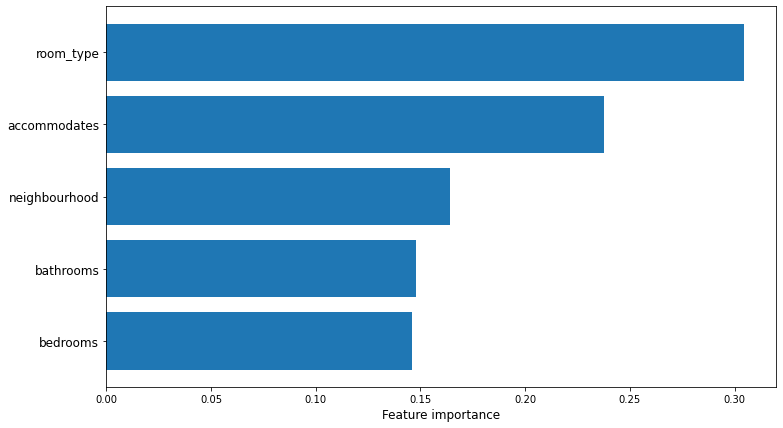

In [14]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns[indices]
importances = importances[indices]

fig, ax = plt.subplots(figsize=(12, 7))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), features, fontsize=12)
ax.invert_yaxis()
ax.set_xlabel("Feature importance", fontsize=12)

plt.show()

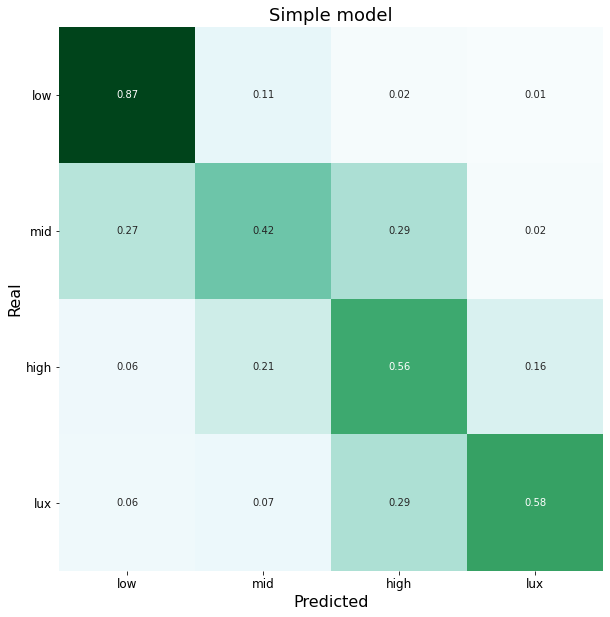

In [15]:
classes = [0, 1, 2, 3]
labels = ['low', 'mid', 'high', 'lux']

c = confusion_matrix(y_test, y_pred)
c = c / c.sum(axis=1).reshape(len(classes), 1)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(c, annot=True, cmap='BuGn', square=True, fmt='.2f', annot_kws={'size': 10}, cbar=False)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Real', fontsize=16)
plt.xticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.yticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.title("Simple model", fontsize=18)

plt.show()

In [16]:
maps = {'0.0': 'low', '1.0': 'mid', '2.0': 'high', '3.0': 'lux'}

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame.from_dict(report).T[:-3]
df_report.index = [maps[i] for i in df_report.index]
df_report

,precision,recall,f1-score,support
low,0.765245,0.867857,0.813327,3080.0
mid,0.634119,0.420857,0.505932,2685.0
high,0.473168,0.561259,0.513463,1461.0
lux,0.297297,0.584071,0.394030,226.0


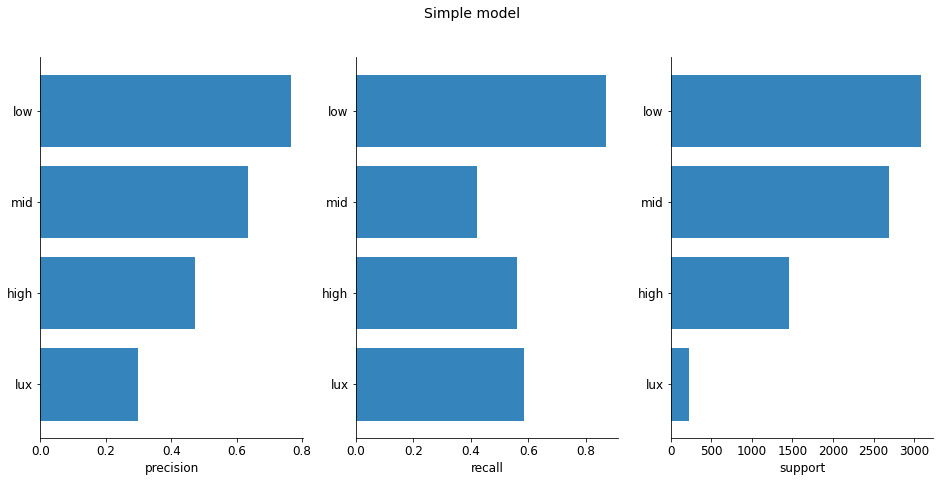

In [17]:
metrics = ['precision', 'recall', 'support']

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 7))

for i, ax in enumerate(axes):

    ax.barh(df_report.index, df_report[metrics[i]], alpha=0.9)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(metrics[i], fontsize=12)
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle("Simple model", fontsize=14)
plt.show()